In [3]:
import os
import random
import math

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2



import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator

import  torchvision.transforms.functional as F

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import xml.etree.ElementTree as ET
import collections
from torchvision.datasets.voc import VisionDataset

from functions import *
from functions_torch import *


import albumentations as A
from albumentations.pytorch import ToTensorV2



In [4]:
params = {}
params['target_size']=(2000,1500)
params['batch_size'] = 1
params['lr'] = 0.001

voc_root = '../../ladd-and-weights/dataset/full_train_ds'
weights_root = '../../ladd-and-weights/weights/torch'



In [10]:
# Reworked class from pytorch (see https://pytorch.org/vision/0.8/_modules/torchvision/datasets/voc.html#VOCDetection)

class LADDDataSET(torchvision.datasets.VisionDataset):
    def __init__(
            self,
            root: str,
            image_set: str,
            transforms: Optional[Callable] = None):     
        super(LADDDataSET, self).__init__(root, transforms=transforms)
        self.image_set = image_set

        voc_root = root
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.')

        splits_dir = os.path.join(voc_root, 'ImageSets/Main')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))
        
#     def __getitem__(self, index: int) -> Tuple[Any, Any]:
#         """
#         Args:
#             index (int): Index

#         Returns:
#             tuple: (image, target) where target is a dictionary of the XML tree.
#         """
#         img = Image.open(self.images[index]).convert('RGB')
#         description = LADDDataSET.parse_voc_xml(
#             ET.parse(self.annotations[index]).getroot())

#         # get bounding box coordinates 
#         num_objs = len(description['annotation']['object'])
#         boxes = []
#         for l in description['annotation']['object']:
#             bb = l['bndbox']
#             boxes.append([int(bb['xmin']), int(bb['ymin']), int(bb['xmax']), int(bb['ymax'])])

#         target = {}
#         target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)         # there is only one class            
#         target["labels"] = labels = torch.ones((num_objs,), dtype=torch.int64)
        
#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

    def __getitem__(self, idx):
#         label = self.labels[idx]
#         file_path = self.file_paths[idx]

        # Read an image with OpenCV
        image = cv2.imread(self.images[index])
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        description = LADDDataSET.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        # get bounding box coordinates 
        num_objs = len(description['annotation']['object'])
        boxes = []
        for l in description['annotation']['object']:
            bb = l['bndbox']
            boxes.append([int(bb['xmin']), int(bb['ymin']), int(bb['xmax']), int(bb['ymax'])])

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)         # there is only one class            
        target["labels"] = labels = torch.ones((num_objs,), dtype=torch.int64)
        

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, target

    def __len__(self) -> int:
        return len(self.images)

    @staticmethod
    def parse_voc_xml(node: ET.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(LADDDataSET.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == 'annotation':
                def_dic['object'] = [def_dic['object']]
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [11]:
# Pytorch implemenation of retinanet doesn't supports train on Images without any objects (which, probably need to be fixed)
# see https://github.com/pytorch/vision/blob/master/torchvision/models/detection/retinanet.py#L475
# As a temporary solution, yet, we just filtering out empty images

splits_dir = os.path.join(voc_root, 'ImageSets/Main') 
annotation_dir = os.path.join(voc_root, 'Annotations')

with open(os.path.join(splits_dir,'train.txt'), "r") as f:
    file_names = [x.strip() for x in f.readlines()]

non_empty = []
for a in file_names:
    description = LADDDataSET.parse_voc_xml(
        ET.parse(os.path.join(annotation_dir, a + ".xml")).getroot()
    )
    num_objs = len(description['annotation']['object'])
    if num_objs > 0:
        non_empty.append(a+'\n')
        
with open(os.path.join(splits_dir,'train_non_empty.txt'), "w") as f:
    f.writelines(non_empty)

print('Total images '+str(len(file_names)), ' non empty: '+str(len(non_empty)))
                                                
                                    
        

Total images 1220  non empty: 1180


In [15]:
albumentations_transform = A.Compose([
    A.Resize(params['target_size'][0],params['target_size'][1]), 
#     A.RandomCrop(224, 224),
#     A.HorizontalFlip(),
#     A.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     ),
    ToTensorV2()
])

In [16]:
# # test DS
# im_idx = 99

dataset = LADDDataSET(voc_root,'test',albumentations_transform(train=True,target_size=params['target_size'])) 
(image,target) = dataset[im_idx] 
im = F.to_pil_image(image)
draw = ImageDraw.Draw(im)

for bb in target['boxes']:
    draw.line([(bb[0], bb[1]), (bb[0], bb[3]), (bb[2], bb[3]),
               (bb[2], bb[1]), (bb[0], bb[1])], width=4, fill=(255, 0, 0))

im.show()

KeyError: 'image'

In [5]:
dataset_train = LADDDataSET(voc_root,'train_non_empty',get_transform(train=True,target_size=params['target_size'])) 
dataset_val = LADDDataSET(voc_root,'val',get_transform(train=False,target_size=params['target_size'])) 

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4
     ,collate_fn=collate_fn
)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4
     ,collate_fn=collate_fn
)


In [8]:
anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [16, 32, 64, 128, 256])
aspect_ratios = ((0.5, 1.0, 2.0, 3.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(
    anchor_sizes, aspect_ratios
)

In [12]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=True, 
                                                           min_size=params['target_size'][0], max_size = params['target_size'][1],
                                                           trainable_backbone_layers = 0, anchor_generator=anchor_generator)
# Nees to define pretrained_backbone to use trainable_backbone_layers, otherwise it's ignored
model.load_state_dict(torch.load(os.path.join(weights_root,'pretrain','resnet50_SDD.pth')), strict=False)


<All keys matched successfully>

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=True, 
#                                                            min_size=params['target_size'][0], max_size = params['target_size'][1],
#                                                            trainable_backbone_layers = 0)
# # Nees to define pretrained_backbone to use trainable_backbone_layers, otherwise it's ignored
# model.load_state_dict(torch.load('/app/host/lacmus/weights/resnet50_FRCNN_SDD_epoch_4.pth'), strict=False)



In [13]:
# the computation device
device = torch.device('cuda')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, weight_decay=0.0005) 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [14]:
for epoch in range(10): # train without backbone

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    print ("Train done, evaluating.")
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    inference_res = evaluate(model,data_loader_val)
    print('Inference done, computing mAp : ')
    print(evaluate_res(inference_res, iou_threshold = 0.5, score_threshold = 0.05))    
    print(evaluate_res(inference_res, iou_threshold = 0.6, score_threshold = 0.05))
    print('Epoch Done')
torch.save(model.state_dict(), 'resnet50_RetinaNet_LADD_head.pth')

Epoch: [0]  [   0/1180]  eta: 0:33:30  lr: 0.000002  loss: 1.5621 (1.5621)  classification: 0.7893 (0.7893)  bbox_regression: 0.7728 (0.7728)  time: 1.7040  data: 1.4082  max mem: 1173
Epoch: [0]  [ 100/1180]  eta: 0:06:19  lr: 0.000102  loss: 1.2378 (1.3627)  classification: 0.6083 (0.6825)  bbox_regression: 0.6193 (0.6803)  time: 0.3181  data: 0.0773  max mem: 1258
Epoch: [0]  [ 200/1180]  eta: 0:05:57  lr: 0.000202  loss: 1.2271 (1.3502)  classification: 0.5856 (0.6920)  bbox_regression: 0.5578 (0.6583)  time: 0.3822  data: 0.1411  max mem: 1258
Epoch: [0]  [ 300/1180]  eta: 0:05:19  lr: 0.000302  loss: 1.0220 (1.2511)  classification: 0.4324 (0.6264)  bbox_regression: 0.5416 (0.6247)  time: 0.3539  data: 0.1014  max mem: 1258
Epoch: [0]  [ 400/1180]  eta: 0:04:42  lr: 0.000402  loss: 0.9753 (1.1857)  classification: 0.3868 (0.5774)  bbox_regression: 0.5329 (0.6082)  time: 0.3425  data: 0.0968  max mem: 1258
Epoch: [0]  [ 500/1180]  eta: 0:04:07  lr: 0.000501  loss: 0.9605 (1.1530) 

In [33]:
import gc
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()

In [6]:
anchor_sizes = tuple((x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3))) for x in [16, 32, 64, 128, 256])
aspect_ratios = ((0.5, 1.0, 2.0, 3.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(
    anchor_sizes, aspect_ratios
)
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=True, 
                                                           min_size=params['target_size'][0], max_size = params['target_size'][1],
                                                           trainable_backbone_layers = 5, anchor_generator=anchor_generator)
# model.load_state_dict(torch.load('resnet50_RetinaNet_LADD_head.pth'), strict=True)
model.load_state_dict(torch.load('resnet50_FRCNN_LADD_epoch_9.pth'), strict=True)



<All keys matched successfully>

In [7]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=True, 
#                                                            min_size=params['target_size'][0], max_size = params['target_size'][1],
#                                                            trainable_backbone_layers = 5)
# model.load_state_dict(torch.load('/app/host/lacmus/weights/resnet50_FRCNN_LADD_head.pth'), strict=True)


In [8]:
# the computation device
device = torch.device('cuda')
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, weight_decay=0.0005) 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=4,
                                               gamma=0.1)


In [9]:
for epoch in range(10): # train with backbone now

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    print ("Train done, evaluating.")
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    inference_res = evaluate(model,data_loader_val)
    print('Inference done, computing mAp : ')
    print(evaluate_res(inference_res, iou_threshold = 0.5, score_threshold = 0.05))    
    print(evaluate_res(inference_res, iou_threshold = 0.6, score_threshold = 0.05))
    print('Epoch Done')
    torch.save(model.state_dict(), 'resnet50_RN_LADD_epoch_%i.pth'%(epoch+10))

# was    
# Epoch: [9] Total time: 0:09:23 (0.4774 s / it)
# Train done, evaluating.
# Inference done, computing mAp : 
# 0.8940549518273289
# 0.8334125499913912

Epoch: [0]  [   0/1180]  eta: 0:40:44  lr: 0.000002  loss: 0.3141 (0.3141)  classification: 0.0657 (0.0657)  bbox_regression: 0.2484 (0.2484)  time: 2.0720  data: 1.5392  max mem: 2255
Epoch: [0]  [ 100/1180]  eta: 0:08:21  lr: 0.000102  loss: 0.2597 (0.2940)  classification: 0.0632 (0.0910)  bbox_regression: 0.2051 (0.2030)  time: 0.4530  data: 0.0128  max mem: 2586
Epoch: [0]  [ 200/1180]  eta: 0:07:32  lr: 0.000202  loss: 0.2337 (0.3052)  classification: 0.0481 (0.0974)  bbox_regression: 0.1650 (0.2078)  time: 0.4587  data: 0.0146  max mem: 4934
Epoch: [0]  [ 300/1180]  eta: 0:06:45  lr: 0.000302  loss: 0.2788 (0.3068)  classification: 0.0782 (0.0993)  bbox_regression: 0.2087 (0.2075)  time: 0.4585  data: 0.0126  max mem: 4934
Epoch: [0]  [ 400/1180]  eta: 0:05:58  lr: 0.000402  loss: 0.3116 (0.3124)  classification: 0.0906 (0.1006)  bbox_regression: 0.2218 (0.2118)  time: 0.4554  data: 0.0108  max mem: 4934
Epoch: [0]  [ 500/1180]  eta: 0:05:12  lr: 0.000501  loss: 0.2698 (0.3147) 

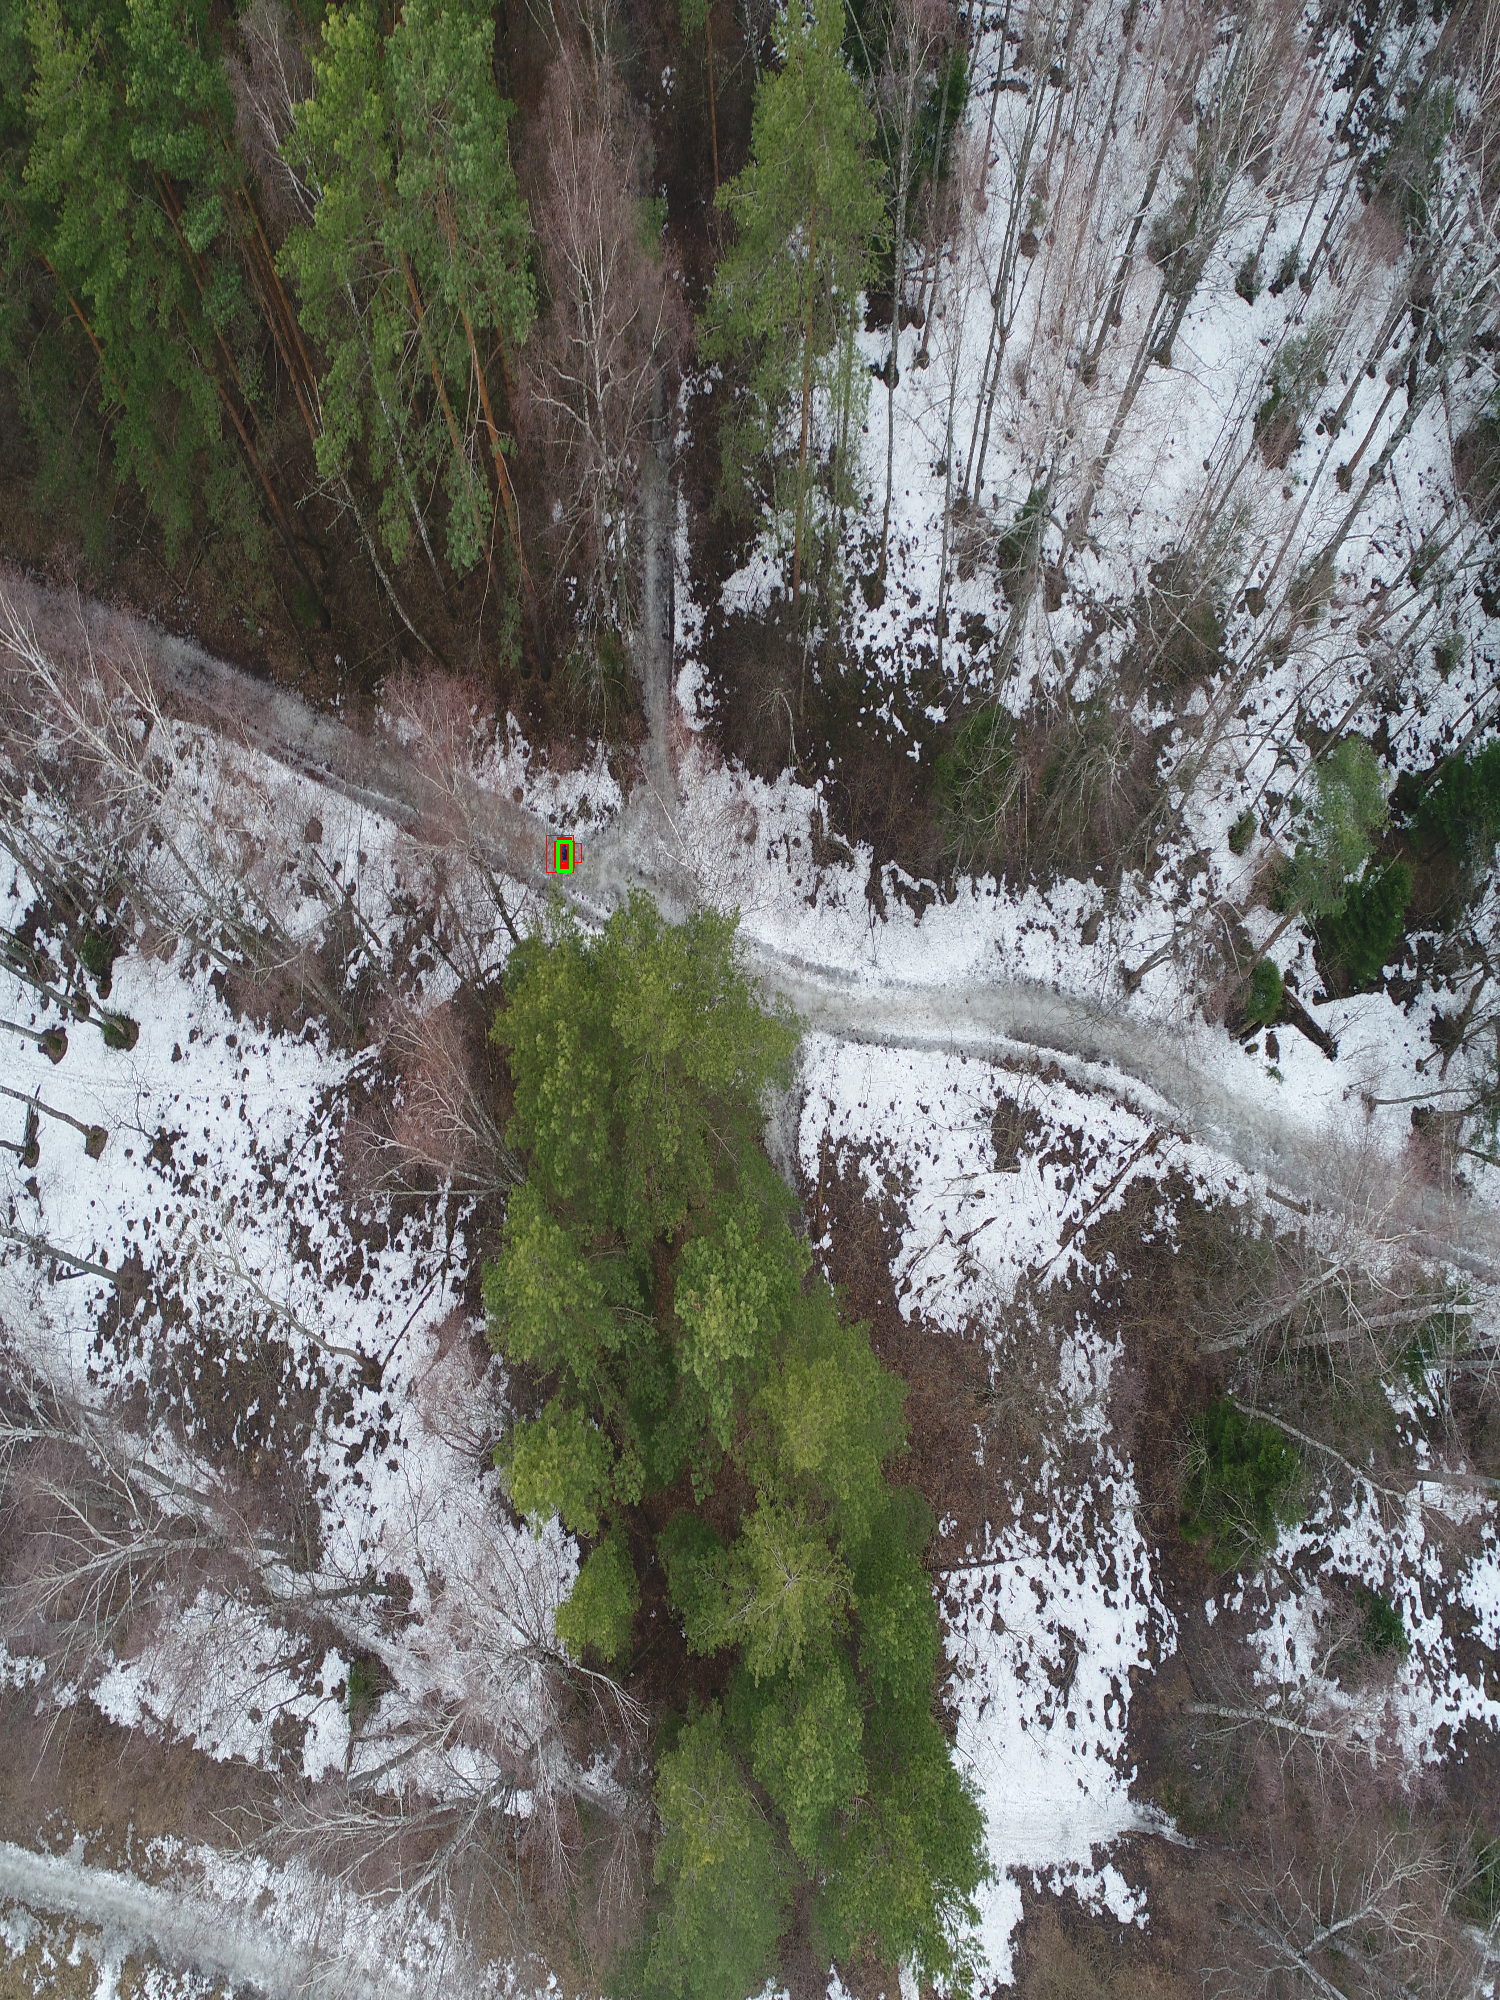

In [10]:
# # uncomment to test evaluation model and show detections

dataset_test = LADDDataSET(voc_root,'test',get_transform(train=False,target_size=params['target_size'])) 
data_loader_test = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=1
     ,collate_fn=collate_fn
)

image_idx = 0

cpu_device = torch.device("cpu")
model.eval()
for images, targets in data_loader_test:
    g_images = list(img.to(device) for img in images)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    outputs = model(g_images)

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    res = targets, outputs
    break


im = F.to_pil_image(images[image_idx])
targets
# im = to_pil_image(dataset[10][0])
draw = ImageDraw.Draw(im)

for idx in range(len(outputs[image_idx]['boxes'])):
    width = math.ceil(outputs[image_idx]['scores'][idx]*10)
    bb = outputs[0]['boxes'][idx]
    draw.line([(bb[0], bb[1]), (bb[0], bb[3]), (bb[2], bb[3]),
               (bb[2], bb[1]), (bb[0], bb[1])], width=width, fill=(255, 0, 0))

for bb in targets[image_idx]['boxes'][:10]:
    draw.line([(bb[0], bb[1]), (bb[0], bb[3]), (bb[2], bb[3]),
               (bb[2], bb[1]), (bb[0], bb[1])], width=4, fill=(0,255, 0))
im.show()



In [ ]:
img =  Image.open('..\').convert('RGB')
g_images = list(img.to(device) for img in images)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    outputs = model(g_images)

    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    res = targets, outputs
    break
